# PyTorch Tutorial

In this tutorial, we will go through the basics of PyTorch, training models on the MNIST dataset.

Why PyTorch:

- PyTorch 

>**+** Dynamic graphs run in a pythonic way, making it easier to understand what some piece of code is doing and to debug

>**+** Offers a good amount of pretrained models and modules.

> **-** It is still a young framework, so not as widely used as others

 

- Keras

>**\+** Easiest framework to code simple models

>**\-** Lack of flexibility:  It is not made for models that use configurations that are not common

 

- TensorFlow

>**+** Framework usually used in industry, since it has TensorFlow serving, a tool to deploy models in production

>**-** Static graph runs out of the python code, making it harder to debug

>**-** Not well organized so far in terms of pre-coded layers and models (Tensorflow 2.0 should change that)


**>** PyTorch ends up being a good option for research and for learning deep learning, since it is as flexible as TensorFlow, but easier to use for prototyping.


In [11]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Tensor basics

PyTorch tensors are like numpy arrays, but that can be used with PyTorch modules and can be sent to GPUs. Several functions are similar to numpy functions, but several are not. Most tensor functions are listed in https://pytorch.org/docs/stable/torch.html#tensors or in https://pytorch.org/docs/stable/tensors.html

Tensor shapes:
- For linear layers: Batch Size X Channels
- For 2d Convolutional Layer: Batch Size X Channels X Height X Width

#### Example of a few tensor operations

You can create tensors of different types:

In [12]:
x = torch.ones(6, 3, dtype=torch.long)
print(x)

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])


Use tensor.size() to get shape of tensor:



In [13]:
print(x.size())

torch.Size([6, 3])


Use tensor.view to reshape tensors:

In [14]:
print(x.view(3,3,2).size())

torch.Size([3, 3, 2])


In [15]:
print(torch.sum(x, dim = 1))

tensor([3, 3, 3, 3, 3, 3])


#### Tensor devices and conversions

Tensors can be converted back and forth from numpy arrays:

In [16]:
x = torch.tensor(np.array([[1 , 2],[3, 4]]))
print(x)

tensor([[1, 2],
        [3, 4]])


In [17]:
print(x.numpy())

[[1 2]
 [3 4]]


Tensors can be sent back and forth from GPUs:

In [18]:
x = x.cuda()
print(x)

tensor([[1, 2],
        [3, 4]], device='cuda:0')


In [19]:
x = x.cpu()
print(x)

tensor([[1, 2],
        [3, 4]])


Tensors should be on the same device as the model/module you run them on. So, to use GPU, you should have your input tensors stored on a GPU and your model stored on a GPU. For storing outputs of models or losses, it is better to transform them into numpy variables first. You can only convert to numpy tensors that are on a CPU:

In [20]:
# x = x.cuda().numpy()

## Preparing data

#### Datasets

The Dataset class in PyTorch is the one used to define data loading and transformations. For a custom dataset not offered by PyTorch, you will usually have to inherit from the dataset class to define how to load your data. More details here: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset. Examples of this are provided in the Assignment 2 notebook. An object of this class can be indexed like python lists to get a specific dataset example.

In [21]:
train_dataset = torchvision.datasets.MNIST(root = './', download=True, train = True, 
                           transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5,), (0.5,)),
]))

#using test set as validation set for practical reasons in the tutorial
# please do not do this to evaluate models
val_dataset = torchvision.datasets.MNIST(root = './', download=True, train = False, 
                           transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5,), (0.5,)),
]))

Processing...
Done!


60000
10000
tensor(5)


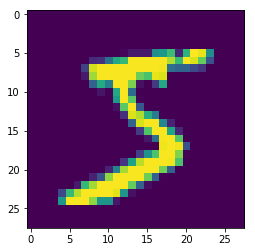

In [22]:
print(len(train_dataset))
print(len(val_dataset))

plt.imshow(train_dataset[0][0][0,:,:])
print(train_dataset[0][1])

#### Transforms

PyTorch offers a few preprocessing functions for images (https://pytorch.org/docs/stable/torchvision/transforms.html). It contains both non-random transformations, for example resizing or normalizing images, and random transformations, for example random crops or random rotation.

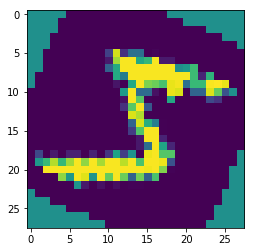

In [23]:
plt.imshow(np.array(torchvision.transforms.RandomRotation(degrees = 25)(Image.fromarray(train_dataset[0][0][0,:,:].numpy()))))

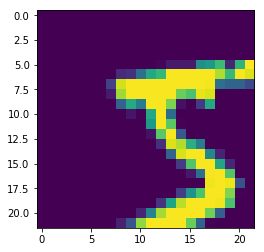

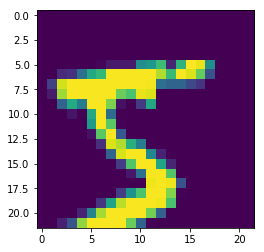

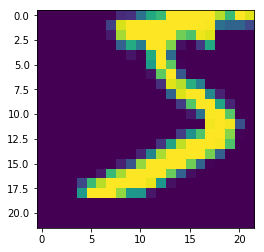

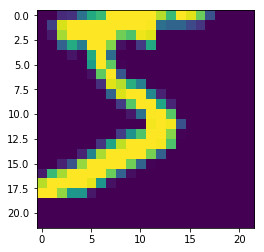

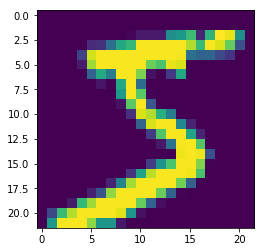

In [24]:
for image in torchvision.transforms.FiveCrop(size = 22)(Image.fromarray(train_dataset[0][0][0,:,:].numpy())):
  plt.imshow(np.array(image))
  plt.show()

#### DataLoaders

The DataLoader class handles how the dataset is sampled for training or testing. The main functions of it are handling the shuffling of the dataset, the batch size and the parallel loading of data. You will almost always directly use the provided class from PyTorch: (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [25]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = 256, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 256, num_workers = 8)

## Creating Models

We will create three models here to exemplify different ways of constructing them.

Models are derived classes of the torch.nn.Module class, and are usually composed of several modules. The nn package should contain all the important layers for deep learning: https://pytorch.org/docs/stable/nn.html . Some of these important layers are Linear, MaxPool2d, AvgPool2d, Conv2d, Dropout2d, BatchNorm2d.

#### Creating with Sequential

The Sequential module (https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential) is one way of creating models, when they are a simple sequence of other modules:

In [26]:
model1 = torch.nn.Sequential(torch.nn.Linear(in_features = 28*28, out_features = 100), torch.nn.ReLU(),
                    torch.nn.Linear(in_features = 100, out_features = 10))
model1 = model1.cuda()

#### Creating with Module class inheritance

You can also inherit from the Module class to create a model. You should declare a forward function, which defines what feeding the model with an input does. The backward pass is defined by PyTorch automatically.

In [27]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.convolution_layer_1 = torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)
        self.relu = torch.nn.ReLU()
        self.maxpooling_layer = torch.nn.MaxPool2d(kernel_size = 2)
        self.convolution_layer_2 = torch.nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 5)
        self.fully_connected_layer = torch.nn.Linear(in_features = 256, out_features = 10)

    def forward(self, x):
        x = self.convolution_layer_1(x)
        x = self.relu(x)
        x = self.maxpooling_layer(x)
        x = self.convolution_layer_2(x)
        x = self.relu(x)
        x = self.maxpooling_layer(x)
        
        #flattening the tensor so that it can serve as input to a linear layer
        x = x.view(x.size(0), -1)
        x = self.fully_connected_layer(x)
        return x
      
model2 = ConvNet()
model2 = model2.cuda()

#### Weight initialization

All weights are initialized using a good initialization rule. But you can also set your own rules using modules from torch.nn.init (https://pytorch.org/docs/master/nn.html#torch-nn-init)

In [28]:
torch.nn.init.xavier_normal_(model2.convolution_layer_1.weight);

#### Creating with pre-defined models

PyTorch offers a few pre-built models with optional pretrained weights on ImageNet (https://pytorch.org/docs/stable/torchvision/models.html)

In [29]:
model3 = torchvision.models.resnet18(pretrained = True)
print(model3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/u0579755/.torch/models/resnet18-5c106cde.pth
52.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [30]:
print(model3.fc)
print(model3.conv1)
model3.fc = torch.nn.Linear(in_features = 512, out_features = 10)
model3.avgpool = torch.nn.Sequential()
model3 = model3.cuda()

Linear(in_features=512, out_features=1000, bias=True)
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


## Other declarations for training

#### Loss

PyTorch has several different kinds of losses predefined (https://pytorch.org/docs/stable/nn.html#loss-functions). For this example, we will use CrossEntropyLoss. It is preferable to use the losses that receive logits instead of probabilities because they are numerically more stable. You should be careful to have a model output which matches what your loss expects as input. Note that the models defined in the Models section above do not have a Softmax output. Instead, we are going to use a loss function that does the softmax for us. Also, the CrossEntropyLoss receives classes as target, and not one-hot vectors. This means we do not need to change the labels from the dataset to feed it to the loss.

In [31]:
criterion = torch.nn.CrossEntropyLoss()

#### Optimizer

PyTorch has several different kinds of optimizers predefined (https://pytorch.org/docs/stable/optim.html). You should provide a specific set of weights to each optimizer instance to specify which weights it should optimize. More details on the use of the optimizer will be presented in the training section of this tutorial.

We will use the Adam optimizer since usually it is the optimizer that presents the fastest convergence.

In [32]:
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.01)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.0005)
optimizer3 = torch.optim.Adam(model3.parameters(), lr = 0.0001)

## Training a Model

1) **Loops:** We will have two loops, one for epochs and one for batches

2) **Model mode:** Remember to toggle train or eval mode

3) **zero_grad:** PyTorch accumulates gradients by default. This means that in the rare cases we want to run backpropagation more than once for the same batch, it will remember the gradients for both backpropagations.  However, for every new batch, we want the gradients to have no influences from the gradients of the previous batch. So at the start of every batch iteration, we call the zero_grad() function. 

4) **backward:** To run backpropagation, we need to call the backward() function for the loss

5) **step:** To update the parameters, we need to call the step function for the optimizer of those parameters

6)  **Monitoring:**
- We want to monitor a few metrics during training to be able to compare different models, check that the model is learning something and check if the model has converged. For this, in this tutorial we will print the training loss value. It is also important to follow the training and validation accuracy for every epoch. You could do this more frequently than every epoch, if needed.
- TensorBoard, for TensorFlow, is an even better way for monitoring training. For PyTorch, you can use tensorboardX (https://github.com/lanpa/tensorboardX) to create TensorBoard files, and then use TensorBoard to visualize them.

7)  **Memory leak:** Be careful not to store tensors from several different iterations, as this may cause memory leaks. Use .item() to convert a single-valued tensor to a python number, or .cpu().numpy() to convert a larger tensor to a numpy array before storing them.

In [33]:
for epoch in range(5): # 1)
  
    model1.train() # 2)
    model2.train() # 2)
    model3.train() # 2)
    
    losses1 = []
    losses2 = []
    losses3 = []
    for images, targets in train_loader: # 1)
      
        optimizer1.zero_grad() # 3)
        optimizer2.zero_grad() # 3)
        optimizer3.zero_grad() # 3)
        
        #putting variables on GPU since model is on GPU
        images = images.cuda()
        targets = targets.cuda()
        
        #running each model by adapting the imagees tensor to the expected input size of each model
        out1 = model1(images.view(images.size(0), -1))
        out2 = model2(images)
        out3 = model3(images.expand(-1, 3, -1, -1))
        
        #calculating the losses with the defined criterion
        loss1 = criterion(out1, targets)
        loss2 = criterion(out2, targets)
        loss3 = criterion(out3, targets)
        
        loss1.backward() # 4)
        loss2.backward() # 4)
        loss3.backward() # 4)
        
        optimizer1.step() # 5)
        optimizer2.step() # 5)
        optimizer3.step() # 5)
        
        losses1.append(loss1.item()) # 6) 7)
        losses2.append(loss2.item()) # 6) 7)
        losses3.append(loss3.item()) # 6) 7)
        
    print('Epoch ' + str(epoch)) # 6)
    print('loss1: ' + str(np.mean(losses1))) # 6)
    print('loss2: ' + str(np.mean(losses2))) # 6)
    print('loss3: ' + str(np.mean(losses3))) # 6)

Epoch 0
loss1: 0.5805379294968666
loss2: 0.8400896666531867
loss3: 0.18907283061045282
Epoch 1
loss1: 0.2595943514336931
loss2: 0.19863181913152655
loss3: 0.03004087877875947
Epoch 2
loss1: 0.22444843003090392
loss2: 0.1293274666876235
loss3: 0.01729122882590015
Epoch 3
loss1: 0.20995230922039518
loss2: 0.10241275732504561
loss3: 0.013662166734959217
Epoch 4
loss1: 0.19130834927584262
loss2: 0.08645372189422872
loss3: 0.011071503385554682


## Evaluating model

Evaluating the model has a similar structure to training the model, but there is no need for gradients and optimizers, and you should toggle the eval mode of the model.

In [34]:
#turning off gradients will make model run slightly faster
with torch.no_grad():
    model1.eval()
    model2.eval()
    model3.eval()

    n_corrects1 = 0
    n_corrects2 = 0
    n_corrects3 = 0
    for images, targets in val_loader:

        images = images.cuda()
        targets = targets.cuda()

        out1 = model1(images.view(images.size(0), -1))
        out2 = model2(images)
        out3 = model3(images.expand(-1, 3, -1, -1))
        
        # Counting how many correct predictions were made for this batch
        # to get the prediction of each model, find the index 
        # of the maximum logit in each batch example
        n_corrects1 += torch.sum(torch.argmax(out1, dim = 1)==targets).item()
        n_corrects2 += torch.sum(torch.argmax(out2, dim = 1)==targets).item()
        n_corrects3 += torch.sum(torch.argmax(out3, dim = 1)==targets).item()

    print('accuracy1: ' + str(n_corrects1/len(val_dataset)))
    print('accuracy2: ' + str(n_corrects2/len(val_dataset)))
    print('accuracy3: ' + str(n_corrects3/len(val_dataset)))

accuracy1: 0.9344
accuracy2: 0.9782
accuracy3: 0.9902


Now we combine training and evaluation in the same cell to follow validation and training during training. The code is just a combined copy and paste from the two previous code cells.

In [35]:
#continuing training but now monitoring accuracy for training and validation
for epoch in range(10): 
    model2.train() 
    model3.train() 
    
    losses1 = []
    losses2 = []
    losses3 = []
    
    #training
    for images, targets in train_loader: 
      
        optimizer1.zero_grad()
        optimizer2.zero_grad() 
        optimizer3.zero_grad() 
        
        images = images.cuda()
        targets = targets.cuda()

        out1 = model1(images.view(images.size(0), -1))
        out2 = model2(images)
        out3 = model3(images.expand(-1, 3, -1, -1))
        

        loss1 = criterion(out1, targets)
        loss2 = criterion(out2, targets)
        loss3 = criterion(out3, targets)
        
        loss1.backward() 
        loss2.backward() 
        loss3.backward() 
        
        optimizer1.step() 
        optimizer2.step() 
        optimizer3.step() 
        
        losses1.append(loss1.item()) 
        losses2.append(loss2.item()) 
        losses3.append(loss3.item()) 
        
    print('Epoch ' + str(epoch)) 
    print('loss1: ' + str(np.mean(losses1))) 
    print('loss2: ' + str(np.mean(losses2))) 
    print('loss3: ' + str(np.mean(losses3))) 
    
    #accuracy for validation
    with torch.no_grad():
        model1.eval()
        model2.eval()
        model3.eval()

        n_corrects1 = 0
        n_corrects2 = 0
        n_corrects3 = 0
        for images, targets in val_loader:

            images = images.cuda()
            targets = targets.cuda()

            out1 = model1(images.view(images.size(0), -1))
            out2 = model2(images)
            out3 = model3(images.expand(-1, 3, -1, -1))

            n_corrects1 += torch.sum(torch.argmax(out1, dim = 1)==targets).item()
            n_corrects2 += torch.sum(torch.argmax(out2, dim = 1)==targets).item()
            n_corrects3 += torch.sum(torch.argmax(out3, dim = 1)==targets).item()
        
        print('Validation:')
        print('accuracy1: ' + str(n_corrects1/len(val_dataset)))
        print('accuracy2: ' + str(n_corrects2/len(val_dataset)))
        print('accuracy3: ' + str(n_corrects3/len(val_dataset)))
        
    #accuracy for training
    with torch.no_grad():
        model1.eval()
        model2.eval()
        model3.eval()

        n_corrects1 = 0
        n_corrects2 = 0
        n_corrects3 = 0
        for images, targets in train_loader:

            images = images.cuda()
            targets = targets.cuda()

            out1 = model1(images.view(images.size(0), -1))
            out2 = model2(images)
            out3 = model3(images.expand(-1, 3, -1, -1))

            n_corrects1 += torch.sum(torch.argmax(out1, dim = 1)==targets).item()
            n_corrects2 += torch.sum(torch.argmax(out2, dim = 1)==targets).item()
            n_corrects3 += torch.sum(torch.argmax(out3, dim = 1)==targets).item()
        print('Training:')
        print('accuracy1: ' + str(n_corrects1/len(train_dataset)))
        print('accuracy2: ' + str(n_corrects2/len(train_dataset)))
        print('accuracy3: ' + str(n_corrects3/len(train_dataset)))

Epoch 0
loss1: 0.17906305552163024
loss2: 0.07529026395145882
loss3: 0.007022672495309343
Validation:
accuracy1: 0.9483
accuracy2: 0.982
accuracy3: 0.9901
Training:
accuracy1: 0.9504833333333333
accuracy2: 0.9791833333333333
accuracy3: 0.9979166666666667
Epoch 1
loss1: 0.1748753548936641
loss2: 0.06841908839947365
loss3: 0.006563607813354503
Validation:
accuracy1: 0.9472
accuracy2: 0.9818
accuracy3: 0.9909
Training:
accuracy1: 0.9503666666666667
accuracy2: 0.9805
accuracy3: 0.9986666666666667
Epoch 2
loss1: 0.17033885244993455
loss2: 0.06284375091657994
loss3: 0.009207224627421733
Validation:
accuracy1: 0.9499
accuracy2: 0.983
accuracy3: 0.9922
Training:
accuracy1: 0.9520166666666666
accuracy2: 0.9830333333333333
accuracy3: 0.9983833333333333
Epoch 3
loss1: 0.16482719303445614
loss2: 0.05774467729349086
loss3: 0.00617296487152418
Validation:
accuracy1: 0.9508
accuracy2: 0.9836
accuracy3: 0.993
Training:
accuracy1: 0.9525
accuracy2: 0.9831333333333333
accuracy3: 0.9992
Epoch 4
loss1: 0.